In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3, MobileNetV2, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
# Path ke direktori train, validation, dan test
train_dir = 'split_dataset_grayscale/train'
val_dir = 'split_dataset_grayscale/val'
test_dir = 'split_dataset_grayscale/test'

In [3]:
# Konfigurasi parameter
num_classes = 4
input_shape = (224, 224, 3)
optimizer = Adam(learning_rate=0.0001)
loss = 'categorical_crossentropy'
activation = 'softmax'
epochs = 50
batch_size = 32

In [4]:
# InceptionV3
pre_trained_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# MobilenetV2
# pre_trained_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

#VGG16
# pre_trained_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [5]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [6]:
x = pre_trained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(num_classes, activation=activation)(x)

In [7]:
# Bangun model akhir
model = Model(pre_trained_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

In [8]:
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

In [9]:
# Augmentasi gambar pada data train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Augmentasi gambar pada data test (hanya rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)

# Augmentasi gambar pada data validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Muat data train dan test menggunakan ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Muat data validation menggunakan ImageDataGenerator
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 2949 images belonging to 4 classes.
Found 635 images belonging to 4 classes.
Found 633 images belonging to 4 classes.


In [10]:
# Lakukan pelatihan model dengan menggunakan data validation
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
)

Epoch 1/50


92/92 [==============================] - 994s 11s/step - loss: 0.8129 - accuracy: 0.6644 - val_loss: 0.5919 - val_accuracy: 0.7681
Epoch 2/50
92/92 [==============================] - 985s 11s/step - loss: 0.5791 - accuracy: 0.7765 - val_loss: 0.6160 - val_accuracy: 0.7566
Epoch 3/50
92/92 [==============================] - 987s 11s/step - loss: 0.5065 - accuracy: 0.8142 - val_loss: 0.5130 - val_accuracy: 0.8059
Epoch 4/50
92/92 [==============================] - 1011s 11s/step - loss: 0.4758 - accuracy: 0.8180 - val_loss: 0.4833 - val_accuracy: 0.8421
Epoch 5/50
92/92 [==============================] - 984s 11s/step - loss: 0.4320 - accuracy: 0.8385 - val_loss: 0.4652 - val_accuracy: 0.7944
Epoch 6/50
92/92 [==============================] - 1231s 13s/step - loss: 0.4448 - accuracy: 0.8365 - val_loss: 0.4785 - val_accuracy: 0.8322
Epoch 7/50
92/92 [==============================] - 1048s 11s/step - loss: 0.4210 - accuracy: 0.8437 - val_loss: 0.5553 - val_accuracy: 0.7632
E

In [11]:
# Simpan model
model.save('model/7/model7.h5')

C:\Users\lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


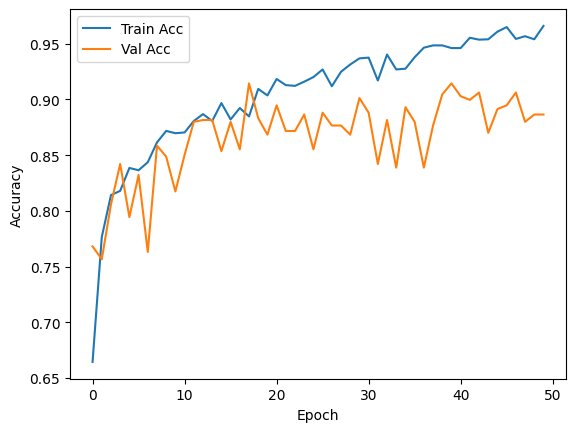

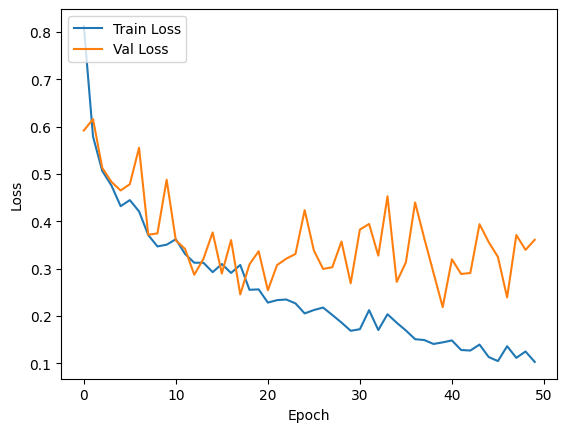

In [12]:
# Plot training accuracy dan loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Acc', 'Val Acc'], loc='upper left')
plt.savefig('model/7/model_accuracy.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc='upper left')
plt.savefig('model/7/model_loss.png')
plt.show()

In [13]:
# Prediksi kelas
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
class_labels = list(test_generator.class_indices.keys())

20/20 [==============================] - 41s 2s/step


In [14]:
# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

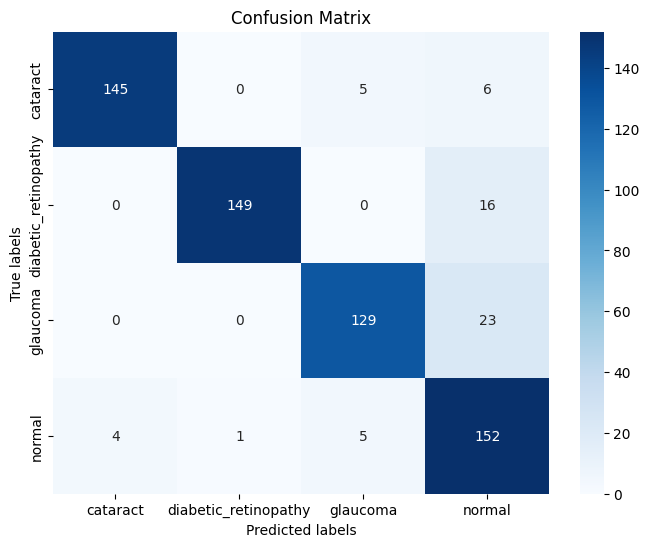

In [15]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig('model/7/confusion_matrix.png')
plt.show()

In [16]:
# Classification report
print('\nClassification Report:')
print(classification_report(test_generator.classes, y_pred, target_names=class_labels))


Classification Report:
                      precision    recall  f1-score   support

            cataract       0.97      0.93      0.95       156
diabetic_retinopathy       0.99      0.90      0.95       165
            glaucoma       0.93      0.85      0.89       152
              normal       0.77      0.94      0.85       162

            accuracy                           0.91       635
           macro avg       0.92      0.90      0.91       635
        weighted avg       0.92      0.91      0.91       635



In [17]:
# Ambil confusion matrix
conf_matrix = confusion_matrix(test_generator.classes, y_pred)

# Hitung nilai sensitivitas dan spesifisitas secara manual
TP = np.diag(conf_matrix)
FP = np.sum(conf_matrix, axis=0) - TP
FN = np.sum(conf_matrix, axis=1) - TP
TN = []
for i in range(len(conf_matrix)):
    temp = np.delete(conf_matrix, i, 0)    # remove ith row
    temp = np.delete(temp, i, 1)  # remove ith column
    TN.append(sum(sum(temp)))
TN = np.array(TN)

accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [18]:
# Print nilai sensitivitas dan spesifisitas untuk setiap kelas
for i, label in enumerate(class_labels):
    print(f'Class: {label}')
    print(f'Accuracy: {accuracy[i]}')
    print(f'Sensitivity: {sensitivity[i]}')
    print(f'Specificity: {specificity[i]}')
    print()

Class: cataract
Accuracy: 0.9763779527559056
Sensitivity: 0.9294871794871795
Specificity: 0.9916492693110647

Class: diabetic_retinopathy
Accuracy: 0.9732283464566929
Sensitivity: 0.9030303030303031
Specificity: 0.997872340425532

Class: glaucoma
Accuracy: 0.9480314960629921
Sensitivity: 0.8486842105263158
Specificity: 0.979296066252588

Class: normal
Accuracy: 0.9133858267716536
Sensitivity: 0.9382716049382716
Specificity: 0.904862579281184

